In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt

client = MongoClient() # we run on localhost and default port
db = client['spotify']

In [44]:
features = db['features']
tracks   = db['tracks']
artists  = db['artists']
albums   = db['albums']
all      = db['all']
complete = db['complete']

In [3]:
def display_results(res):
    for entry in res:
        print(entry)

## Query 1
#### Query: Style the top 10 artists with the highest average album popularity after 2018

In [5]:
all.create_index([("artist_id", 1)])

'artist_id_1'

In [54]:
import datetime
query1 =  [
  {
    '$match': {
      'album_type': "album",
      'release_date': {'$gte': datetime.datetime(2018, 1, 1)}
    }
  },
  {
    '$group': {
      '_id': "$artist_id",
      'totalAlbums': {'$sum': 1},
      'averageAlbumPopularity': {'$avg': "$album_popularity"}
    }
  },
  {
    '$match': {
      'totalAlbums': {'$gte': 4}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_id': "$_id",
      'artist_name': "$name",
      'averageAlbumPopularity': 1
    }
  },
  {
    '$sort': {
      'averageAlbumPopularity': -1
    }
  },
  {
    '$limit': 10
  }
]

result_query1 = list(all.aggregate(query1))


In [55]:
display_results(result_query1)

{'averageAlbumPopularity': 90.56, 'artist_id': '6KImCVD70vtIoJWnq6nGn3'}
{'averageAlbumPopularity': 90.0, 'artist_id': '2uYWxilOVlUdk4oV9DvwqK'}
{'averageAlbumPopularity': 89.33962264150944, 'artist_id': '4q3ewBCX7sLwd24euuV69X'}
{'averageAlbumPopularity': 87.0, 'artist_id': '77SW9BnxLY8rJ0RciFqkHh'}
{'averageAlbumPopularity': 86.0, 'artist_id': '3WGpXCj9YhhfX11TToZcXP'}
{'averageAlbumPopularity': 85.0, 'artist_id': '0iEtIxbK0KxaSlF7G42ZOp'}
{'averageAlbumPopularity': 85.0, 'artist_id': '6qqNVTkY8uBg9cP3Jd7DAH'}
{'averageAlbumPopularity': 84.72340425531915, 'artist_id': '53XhwfbYqKCa1cC15pYq2q'}
{'averageAlbumPopularity': 84.0, 'artist_id': '487N2T9nIPEHrlTZLL3SQs'}
{'averageAlbumPopularity': 84.0, 'artist_id': '1McMsnEElThX1knmY4oliG'}


## Query 2
#### Query: Evolution of song's explicitness over the years (from 1960 on)
Indexes were created to speed up a such heavy query. Without indexes the result couldn't be observed due to the long execution time needed.

In [25]:
all.create_index([( "track_id", 1 )])
all.create_index([( "release_date", 1 )])

'release_date_1'

In [27]:
query_2 = [
    {
        '$match': {
            'album_type': "album",
            'release_date': {'$gte': datetime.datetime(1960, 1, 1)}
        }
    },
    {
        '$group': {
            '_id': {
                'year': {'$year': '$release_date'},
                'explicit': '$explicit'
            },
            'totalTracks': {'$sum': 1}
        }
    },
    {
        '$group': {
            '_id': '$_id.year',
            'explicitCount': {
                '$sum': {
                    '$cond': [{'$eq': ['$_id.explicit', True]}, '$totalTracks', 0]
                }
            },
            'implicitCount': {
                '$sum': {
                    '$cond': [{'$eq': ['$_id.explicit', False]}, '$totalTracks', 0]
                }
            },
            'totalTracks': {'$sum': '$totalTracks'}
        }
    },
    {
        '$project': {
            '_id': 0,
            'year': '$_id',
            'explicitPercentage': {
                '$multiply': [
                    {'$divide': ['$explicitCount', '$totalTracks']},
                    100
                ]
            },
            'implicitPercentage': {
                '$multiply': [
                    {'$divide': ['$implicitCount', '$totalTracks']},
                    100
                ]
            }
        }
    },
    {
        '$sort': {'year': 1}
    }
]

result_query2 = list(all.aggregate(query_2))

In [33]:
display_results(result_query2)

{'year': 1960, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1961, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1962, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1963, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1964, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1965, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1966, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1967, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1968, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1969, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1970, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1971, 'explicitPercentage': 0.1941747572815534, 'implicitPercentage': 99.80582524271846}
{'year': 1972, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0}
{'year': 1973, 'explicitPercentage': 0.34071550255

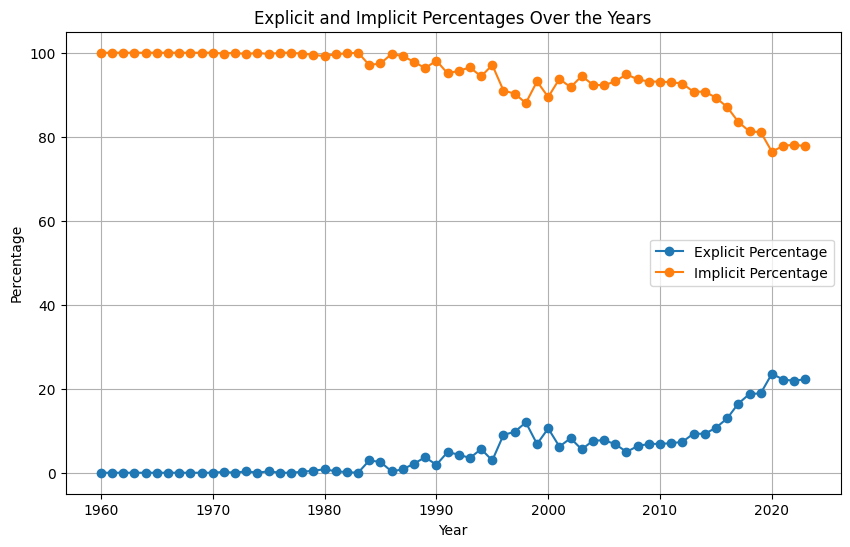

In [29]:
years                = [entry['year']               for entry in result_query2]
explicit_percentages = [entry['explicitPercentage'] for entry in result_query2]
implicit_percentages = [entry['implicitPercentage'] for entry in result_query2]

plt.figure(figsize=(10, 6))
plt.plot(years, explicit_percentages, label='Explicit Percentage', marker='o')
plt.plot(years, implicit_percentages, label='Implicit Percentage', marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Explicit and Implicit Percentages Over the Years')
plt.legend()
plt.grid(True)
plt.show()

## Query 3: get the average instrumentalness of the tracks based on its time signature

In [42]:
query3 = [
    {
        '$group': {
            '_id': '$time_signature',
            'average_danceability': {'$avg': '$danceability'},
            'average_energy': {'$avg': '$energy'},
            'average_valence': {'$avg': '$valence'}
        }
    },
    {
        '$sort': {
            '_id': 1
        }
    },
    {
        '$project': {
            '_id': 0,
            'time_signature': '$_id',
            'average_danceability': 1,
            'average_energy': 1,
            'average_valence': 1
        }
    }
]

result_query3 = list(all.aggregate(query3))
result_query3 = result_query3[1:]

In [43]:
display_results(result_query3)

{'average_danceability': 0.0025912408759124084, 'average_energy': 0.2642535627737226, 'average_valence': 0.001588868613138686, 'time_signature': 0}
{'average_danceability': 0.41776983736762485, 'average_energy': 0.3703698709341906, 'average_valence': 0.3174133080559758, 'time_signature': 1}
{'average_danceability': 0.4430313164594878, 'average_energy': 0.3577192962932455, 'average_valence': 0.3386356197294194, 'time_signature': 3}
{'average_danceability': 0.5964401049574437, 'average_energy': 0.5534127727142146, 'average_valence': 0.4762107191251237, 'time_signature': 4}
{'average_danceability': 0.450119538349691, 'average_energy': 0.3950980574427481, 'average_valence': 0.3200791159578335, 'time_signature': 5}


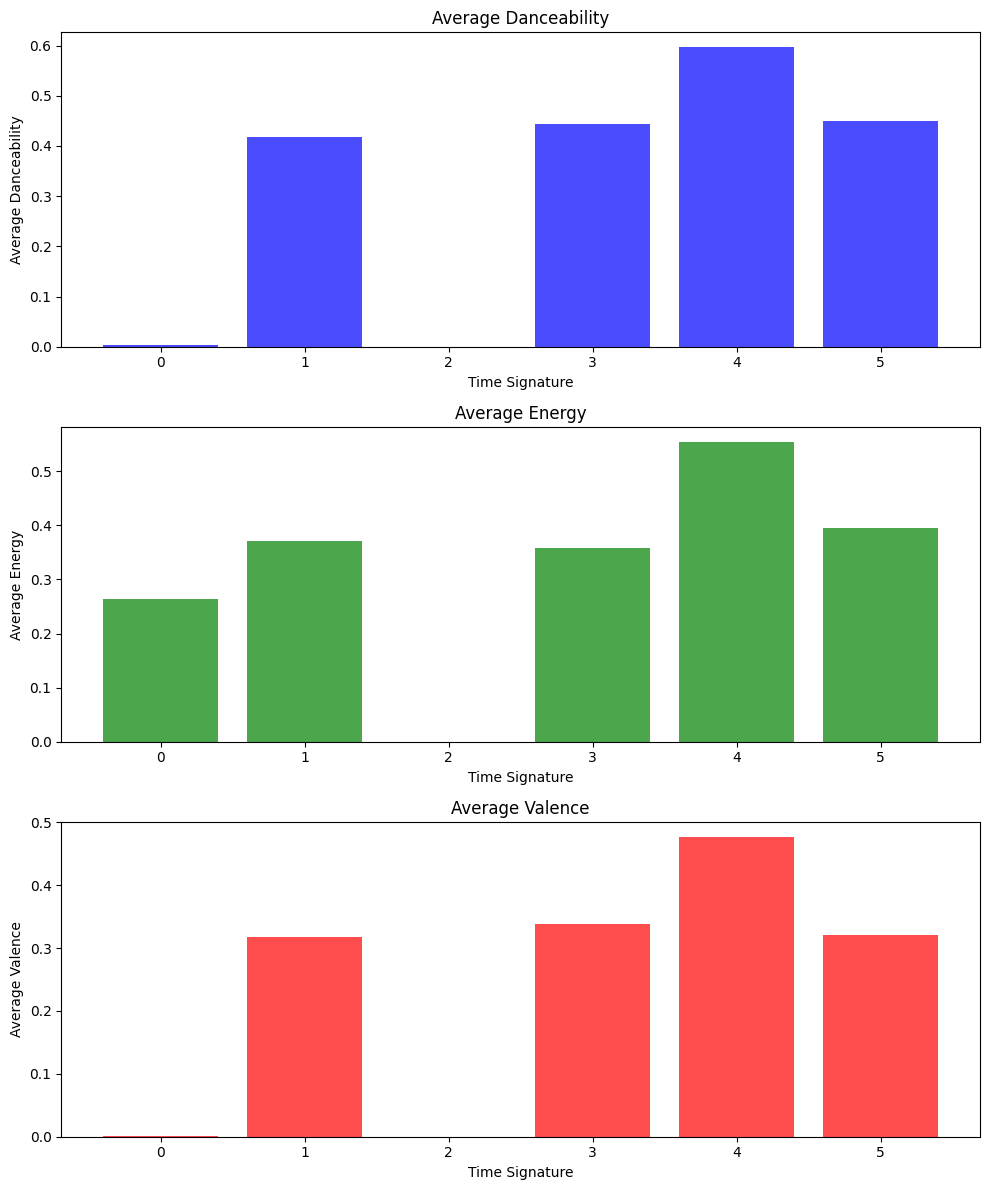

In [44]:
danceability    = [entry['average_danceability'] for entry in result_query3]
energy          = [entry['average_energy'] for entry in result_query3]
valence         = [entry['average_valence'] for entry in result_query3]
time_signatures = [entry['time_signature'] for entry in result_query3]

# Plotting histograms
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot for Average Danceability
axs[0].bar(time_signatures, danceability, color='blue', alpha=0.7)
axs[0].set_title('Average Danceability')
axs[0].set_xlabel('Time Signature')
axs[0].set_ylabel('Average Danceability')

# Plot for Average Energy
axs[1].bar(time_signatures, energy, color='green', alpha=0.7)
axs[1].set_title('Average Energy')
axs[1].set_xlabel('Time Signature')
axs[1].set_ylabel('Average Energy')

# Plot for Average Valence
axs[2].bar(time_signatures, valence, color='red', alpha=0.7)
axs[2].set_title('Average Valence')
axs[2].set_xlabel('Time Signature')
axs[2].set_ylabel('Average Valence')

plt.tight_layout()
plt.show()

## Query 4: find artists popular only in few albums (sbagliata per ora)
Useful for instance if you want to find underground artists that collaborate with big stars.Very likely in those album the one with low popularity will have a big album popularity in that album. Useful also to spot artists that, for instance, wrote a summer-hit but for the rest of the year no one listen to him. Or, artists that had success with an album but not on the whole carrier. Or again, artists that found success only after some period. The query works by finding the stardard deviation of the artist's albums popularity. Artists that wrote less than 3 albums were discarted.

Also album with lowest popularity for each artist weren't counted (it can be their first album) to be more optimistic.

In [ ]:
query_4 = [
    {
        "$group": {
            "_id": "$name",
            "numAlbums": {"$sum": 1},
            "popularityArray": {"$push": {"popularity": "$album_popularity", "album_id": "$album_id", "album_name": "$album_name"}}
        }
    },
    {
        "$match": {
            "numAlbums": {"$gt": 3}  # Exclude artists with less than 3 albums
        }
    },
    {
        "$unwind": "$popularityArray"
    },
    {
        "$sort": {"popularityArray.popularity": 1}
    },
    {
        "$group": {
            "_id": "$_id",
            "popularityArray": {"$push": "$popularityArray"},
            "maxAlbumPopularity": {"$last": "$popularityArray"},
            "avgPopularity": {"$avg": "$popularityArray.popularity"},
            "stdDevPopularity": {"$stdDevPop": "$popularityArray.popularity"}
        }
    },
    {
         '$project': {
            'popularityArray': 0,
             'maxAlbumPopularity':{'album_id':       0}
        }
    },
    {
        "$sort": {"stdDevPopularity": -1}
    },
    {
        "$limit": 30
    }
]
result_query4 = list(all.aggregate(query_4))

In [31]:
display_results(result_query4)

{'_id': 'Amit Trivedi', 'maxAlbumPopularity': {'popularity': 65, 'album_name': 'Dear Zindagi (Original Motion Picture Soundtrack)'}, 'avgPopularity': 44.0, 'stdDevPopularity': 29.698484809834994}
{'_id': 'Red Velvet', 'maxAlbumPopularity': {'popularity': 73, 'album_name': 'Chill Kill - The 3Rd Album'}, 'avgPopularity': 34.934707903780065, 'stdDevPopularity': 28.042294973644843}
{'_id': 'Lynyrd Skynyrd', 'maxAlbumPopularity': {'popularity': 75, 'album_name': 'Second Helping (Expanded Edition)'}, 'avgPopularity': 49.8, 'stdDevPopularity': 27.85964823898536}
{'_id': 'Chris Brown', 'maxAlbumPopularity': {'popularity': 86, 'album_name': '11:11'}, 'avgPopularity': 42.50355329949239, 'stdDevPopularity': 26.64948714401531}
{'_id': 'Simon Franglen', 'maxAlbumPopularity': {'popularity': 63, 'album_name': 'Avatar: The Way Of Water (Original Motion Picture Soundtrack)'}, 'avgPopularity': 48.03448275862069, 'stdDevPopularity': 26.53102641556666}
{'_id': 'Metro Boomin', 'maxAlbumPopularity': {'popul

### Interpretation:
The first artist isn't famous. However, wrote a soundrack for a movie. This rised his popularity's standard deviation.

# Query 5
#### Query: Most important labels for each genre

In [33]:
query_5 =  [
    {
        "$unwind": "$artist_genres",
    },
    {
        "$group": {
            "_id": {
                "genre": "$artist_genres",
                "label": "$label",
            },
            "averagePopularity": {"$avg": "$album_popularity"},
        },
    },
    {
        "$sort": {
            "_id.genre": 1,
            "averagePopularity": -1,
        },
    },
    {
        "$group": {
            "_id": "$_id.label",
            "genres": {"$push": {"genre": "$_id.genre", "popularity": "$averagePopularity"}},
        },
    },
    {
        "$project": {
            "_id": 0,
            "mostImportantLabel": "$_id",
            "highestAveragePopularity": {"$max": "$genres.popularity"},
            "genres": "$genres.genre",
        },
    },
    {
        "$sort": {
            "highestAveragePopularity": -1,
        },
    },
    {
        "$limit": 200
    }
]


result_query5 = list(all.aggregate(query_5))

In [34]:
display_results(result_query5)

{'mostImportantLabel': 'Dead Oceans', 'highestAveragePopularity': 90.0, 'genres': ["['brooklyn indie', 'pov: indie']", "['indie pop', 'la indie', 'pov: indie']"]}
{'mostImportantLabel': 'Cash Money/Drake LP6', 'highestAveragePopularity': 87.0, 'genres': ["['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap']"]}
{'mostImportantLabel': 'Slaughter Gang, LLC/Epic/Boominati Worldwide/Republic', 'highestAveragePopularity': 86.0, 'genres': ["['atl hip hop', 'hip hop', 'rap']"]}
{'mostImportantLabel': 'Columbia', 'highestAveragePopularity': 85.66666666666667, 'genres': ["['acoustic pop', 'ectofolk', 'folk', 'indie folk', 'lilith', 'modern folk rock', 'new americana']", "['adult standards', 'contemporary vocal jazz', 'lounge', 'vocal jazz']", "['adult standards', 'easy listening']", "['adult standards', 'operatic pop', 'soft rock']", "['album rock', 'classic rock', 'hard rock', 'heartland rock', 'mellow gold', 'rock', 'soft rock']", "['album rock', 'classic rock', 'hard rock', 'mell

### Show only the first 50 most important labels (to better visualize the names)

In [35]:
labels = [entry['mostImportantLabel'] for entry in result_query5 if 'genres' in entry]
average_popularities = [entry['highestAveragePopularity'] for entry in result_query5 if 'genres' in entry]
labels = labels[0:50]
average_popularities = average_popularities[0:50]

In [ ]:

# Plotting as a histogram
plt.figure(figsize=(10, 6))
plt.bar(labels, average_popularities, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Highest Average Popularity')
plt.title('Label Importance Based on Highest Average Popularity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Interpretation:


## Query 6
##### Query: find label that release albums prevelently (more than 65%) in the summer


In [37]:
query_6 = [
    {
        '$group': {
            '_id': {
                'label': '$label',
                'album_name': '$album_name',
                'release_date': '$release_date'
            },
            'totalAlbums': {'$sum': 1},
            'summerAlbums': {
                '$max': {
                    '$cond': [
                        {
                            '$or': [
                                {'$eq': [{'$month': '$release_date'}, 6]},  # June
                                {'$eq': [{'$month': '$release_date'}, 7]}   # July
                            ]
                        },
                        1,
                        0
                    ]
                }
            }
        }
    },
    {
        '$group': {
            '_id': {
                'label': '$_id.label'
            },
            'totalAlbums': {'$sum': '$totalAlbums'},
            'summerAlbums': {'$sum': '$summerAlbums'}
        }
    },
    {
        '$project': {
            'label': '$_id.label',
            'totalAlbums': 1,
            'summerAlbums': 1,
            'percentageInSummer': {
                '$multiply': [{'$divide': ['$summerAlbums', '$totalAlbums']}, 100]
            }
        }
    },
    {
        '$match': {
            '$and': [
                {'totalAlbums': {'$gt': 7}},         # labels with at least 8 total albums
                {'percentageInSummer': {'$gt': 70}}  # labels with more than 70% summer albums
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'label': 1,
            'totalAlbums': 1,
            'summerAlbums': 1,
            'percentageInSummer': 1
        }
    },
    {
        '$sort': {'percentageInSummer': -1}
    }
]

result_query6 = list(all.aggregate(query_6))

In [38]:
result_query6

[{'totalAlbums': 9,
  'summerAlbums': 9,
  'label': 'GWK quavon Doss',
  'percentageInSummer': 100.0},
 {'totalAlbums': 97,
  'summerAlbums': 96,
  'label': 'Ocean Distribution FZCO',
  'percentageInSummer': 98.96907216494846},
 {'totalAlbums': 10,
  'summerAlbums': 8,
  'label': 'DJ Stanz',
  'percentageInSummer': 80.0},
 {'totalAlbums': 9,
  'summerAlbums': 7,
  'label': 'Metro Music Creative',
  'percentageInSummer': 77.77777777777779}]

# Query 7
#### Query: Average song name length for each genre

In [45]:
complete.create_index([( "artist_genres", 1 )])

'artist_genres_1'

In [104]:
query_7=[
    {
        "$unwind": "$artist_genres"
    },
    {
        "$group": {
            "_id": {
                "genre": "$artist_genres",
                "artist_id": "$artist_id"
            },
            "avgTrackNameLength": {
                "$avg": {"$strLenCP": "$track_name"}
            },
            "avgWordsPerTrack": {
                "$avg": {
                    "$size": {"$split": ["$track_name", " "]}
                }
            }
        }
    },
    {
        "$group": {
            "_id": "$_id.genre",
            "artistCount": {"$sum": 1},
            "avgTrackNameLength": {"$avg": "$avgTrackNameLength"},
            "avgWordsPerTrack": {"$avg": "$avgWordsPerTrack"}
        }
    },
    {
        "$match": {
            "artistCount": {"$gte": 5}
        }
    },
    {
        "$sort": {
            "avgTrackNameLength": -1
        }
    },
    {
        "$project": {
            "genre": "$_id",
            "avgTrackNameLength": 1,
            "avgWordsPerTrack": 1,
            "_id": 0
        }
    }
]



result_query7 = list(complete.aggregate(query_7))

In [107]:
print("Genres with highest track name length (with at least 5 artists):")
display_results(result_query7[:10])
print("\nGenres with lowest track name length (with at least 5 artists):")
display_results(result_query7[-10:])

Top 10 genres with highest track name length (with at least 5 artists):
{'avgTrackNameLength': 68.11736713499259, 'avgWordsPerTrack': 12.199915984458721, 'genre': 'early romantic era'}
{'avgTrackNameLength': 65.61300979809559, 'avgWordsPerTrack': 12.120837070193797, 'genre': 'classical era'}
{'avgTrackNameLength': 65.2653526947619, 'avgWordsPerTrack': 11.772012509515514, 'genre': 'german baroque'}
{'avgTrackNameLength': 63.65416278868092, 'avgWordsPerTrack': 11.83798962679043, 'genre': 'german romanticism'}
{'avgTrackNameLength': 60.54591567265084, 'avgWordsPerTrack': 9.812043454610988, 'genre': 'karaoke'}
{'avgTrackNameLength': 59.86873675529788, 'avgWordsPerTrack': 10.172023476323757, 'genre': 'orchestral performance'}
{'avgTrackNameLength': 59.836212495109095, 'avgWordsPerTrack': 10.672447078200568, 'genre': 'russian romanticism'}
{'avgTrackNameLength': 59.45189808826172, 'avgWordsPerTrack': 9.953272396454215, 'genre': 'italian opera'}
{'avgTrackNameLength': 58.131064039939176, 'avg

### Interpretation: 
Oldest songs and classical ones have long names, because they contains tipically the modality in which they are played, the collection and sometimes the orchestra. For instance: "Cello Suite No. 1 in G Major BWV1007" is a very long name.
On the other hand, genres with lowest track name are the one from the asian countries, where the alphababet compress the lenght of the names.
## Query 8
##### Query: find the average duration for tracks based on their tempo class

In [108]:
query_8 = [
    {
        "$project": {
            "tempo_class": {
                "$switch": {
                    "branches": [
                        {"case": {"$and": [{"$lt": ["$tempo", 48]}, {"$gte": ["$tempo", 44]}]}, "then": "LARGO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 52]}, {"$gte": ["$tempo", 48]}]}, "then": "LENTO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 56]}, {"$gte": ["$tempo", 52]}]}, "then": "ADAGIO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 60]}, {"$gte": ["$tempo", 56]}]}, "then": "LARGHETTO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 66]}, {"$gte": ["$tempo", 60]}]}, "then": "ADAGIETTO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 72]}, {"$gte": ["$tempo", 66]}]}, "then": "ANDANTE"},
                        {"case": {"$and": [{"$lt": ["$tempo", 80]}, {"$gte": ["$tempo", 72]}]}, "then": "ANDANTINO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 96]}, {"$gte": ["$tempo", 88]}]}, "then": "MODERATO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 112]}, {"$gte": ["$tempo", 96]}]}, "then": "ALLEGRETTO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 126]}, {"$gte": ["$tempo", 112]}]}, "then": "ANIMATO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 140]}, {"$gte": ["$tempo", 126]}]}, "then": "ASSAI"},
                        {"case": {"$and": [{"$lt": ["$tempo", 176]}, {"$gte": ["$tempo", 140]}]}, "then": "VIVACE"},
                        {"case": {"$gte": ["$tempo", 176]}, "then": "PRESTISSIMO"},
                    ],
                    "default": "SLOWEST TIMES"
                }
            },
            "duration_minutes": {"$divide": ["$duration_ms", 60000]}
        }
    },
    {
        "$group": {
            "_id": "$tempo_class",
            "avg_duration": {"$avg": "$duration_minutes"}
        }
    },
    {
        "$project": {
            "tempo_class": "$_id",
            "avg_duration": 1,
            "_id": 0
        }
    }
]

result_query8 = list(complete.aggregate(query_8))

In [109]:
display_results(result_query8)

{'avg_duration': 3.4778735171207127, 'tempo_class': 'VIVACE'}
{'avg_duration': 3.356519298245614, 'tempo_class': 'LARGHETTO'}
{'avg_duration': 3.763146843801568, 'tempo_class': 'ANIMATO'}
{'avg_duration': 3.5537798512678807, 'tempo_class': 'ALLEGRETTO'}
{'avg_duration': 3.8230575639599556, 'tempo_class': 'ASSAI'}
{'avg_duration': 3.5604190239551476, 'tempo_class': 'ANDANTINO'}
{'avg_duration': 3.3695558965652346, 'tempo_class': 'PRESTISSIMO'}
{'avg_duration': 3.306522016153156, 'tempo_class': 'ADAGIETTO'}
{'avg_duration': 3.2373609375, 'tempo_class': 'ADAGIO'}
{'avg_duration': 3.5251283122176393, 'tempo_class': 'ANDANTE'}
{'avg_duration': 3.473595258830664, 'tempo_class': 'MODERATO'}
{'avg_duration': 3.415199651571823, 'tempo_class': 'SLOWEST TIMES'}
{'avg_duration': 2.637751031353135, 'tempo_class': 'LENTO'}
{'avg_duration': 2.4351985267034992, 'tempo_class': 'LARGO'}


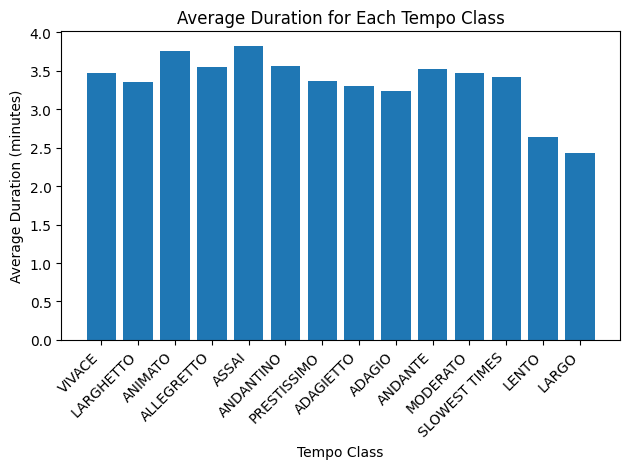

In [110]:

# After obtaining the result
tempo_classes = [doc["tempo_class"] for doc in result_query8]
avg_durations = [doc["avg_duration"] for doc in result_query8]

# Plotting the histogram
plt.bar(tempo_classes, avg_durations)
plt.xlabel('Tempo Class')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Duration for Each Tempo Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Interpretation


# Query 9
### Query: given an artist find similar artists based on their features
Due to the complexity of the query, i stored the average features of the artists on an intermediate collection

In [255]:
query_9_intermediate =[
    {
        "$match":{
            "artist_popularity": {"$gt": 20}
        }
    },
    {
        "$group": {
            "_id": "$artist_id",
            "artist_name": {"$first": "$artist_0"},
            "avg_energy": {"$avg": "$energy"},
            "avg_key": {"$avg": "$key"},
            "avg_mode": {"$avg": "$mode"},
            "avg_instrumentalness": {"$avg": "$instrumentalness"},
            "avg_speechiness": {"$avg": "$speechiness"},
            "avg_tempo": {"$avg": "$tempo"}
        }
    }
]


result_query9_intermediate = list(complete.aggregate(query_9_intermediate, allowDiskUse=True))


In [256]:
result_query9_intermediate

[{'_id': '2oIQCM7hRZI9tS5b9S8rj4',
  'artist_name': 'Tyler ICU',
  'avg_energy': 0.504,
  'avg_key': 1.0,
  'avg_mode': 1.0,
  'avg_instrumentalness': 0.0139,
  'avg_speechiness': 0.0534,
  'avg_tempo': 112.995},
 {'_id': '2MbY32LPINIi9P6PCkrOJI',
  'artist_name': 'MC4D',
  'avg_energy': 0.819,
  'avg_key': 6.0,
  'avg_mode': 1.0,
  'avg_instrumentalness': 0.0,
  'avg_speechiness': 0.0518,
  'avg_tempo': 128.083},
 {'_id': '1nSpOxq3pcgomrfpXudQuq',
  'artist_name': 'Kirk Knight',
  'avg_energy': 0.798,
  'avg_key': 2.0,
  'avg_mode': 1.0,
  'avg_instrumentalness': 0.0,
  'avg_speechiness': 0.345,
  'avg_tempo': 95.79},
 {'_id': '1RulmpMDhjAPg9gx6tAzw9',
  'artist_name': 'Deep Meditation Sleep',
  'avg_energy': 0.14322313636363637,
  'avg_key': 4.454545454545454,
  'avg_mode': 0.4772727272727273,
  'avg_instrumentalness': 0.9165454545454547,
  'avg_speechiness': 0.044543181818181815,
  'avg_tempo': 99.45331818181818},
 {'_id': '4mPGfSPaje7KyKXNlBosQ9',
  'artist_name': 'Flesh-n-Bone',
 

In [257]:
db.AverageFeatures.insert_many(result_query9_intermediate)

InsertManyResult(['2oIQCM7hRZI9tS5b9S8rj4', '2MbY32LPINIi9P6PCkrOJI', '1nSpOxq3pcgomrfpXudQuq', '1RulmpMDhjAPg9gx6tAzw9', '4mPGfSPaje7KyKXNlBosQ9', '1A0QR12gcj2L5hYh1WWDeh', '679N9KYUiZMRnJYts1xDx7', '5DkWvpsvEvNmUd5t0jggNt', '35XHaHt999p2lL6IBJ8Vdq', '5uNTrZ1JlKsnpTeFyKWPYO', '0j49VqyyFRbclqg8Jv3Sdq', '1w4UT8aBCBdpxSRoxvyQ8u', '5EOY61jyr677RT6uZi1YbK', '7GeStAFHjlX9vtLq737M1t', '5lR7yDVN4z9kahOiUSlMhe', '4UWcOm40hIpudoHIcpQQxg', '6NuXlqTU1RF0aIoyD46z5v', '0d1nFNO90pwRmCeeqjOx2Q', '2hS7xiUEsGIzQDFD7aZUYO', '0AHoE4L0FSU0XzYjVnNRUa', '0RvjLz7klSc5lNgxX7EiVZ', '1C12d300JlwsDeUhvqUfhI', '30rNCtpbgMaznRM9h8jlLv', '6L74J3BzylQkJF7rBXTpgT', '5OqR2VGSqk60tMFN8eINMN', '6Q1Ps2F5LkdxLAM6S7KPpt', '0z4gvV4rjIZ9wHck67ucSV', '3w7F4iuvShKcaVSMVikhY4', '3iYS50V5995imQu4WBKSri', '3vHGDuTJOs1D9gAsBPouJ5', '2K0uRwlc2VKeRoWS8Iuija', '71dLP98fcAn3X3dMHpBoHo', '1K0Gi1qUFGSyZUFXvJF4F2', '0kw0RBxQ5PjqTePr8TrTI1', '1cNDP5yjU5vjeR8qMf4grg', '1euy9qBmp31zNChfEVU0FI', '6IYubD5X02Q7MUS10axRUp', '20W9F94ZPbzoMqxuekM

In [267]:
# Specify the reference artist (Eminem in this case)
reference_artist_name = "Eminem"


# Find the reference artist's average values
reference_artist = db.AverageFeatures.find_one({"artist_name": reference_artist_name})

avg_instrumentalness_reference = reference_artist["avg_instrumentalness"]
avg_energy_reference           = reference_artist["avg_energy"]
avg_key_reference              = reference_artist["avg_key"]
avg_mode_reference             = reference_artist["avg_mode"]
avg_speech_reference           = reference_artist["avg_speechiness"]

In [268]:
reference_artist

{'_id': '4utLUGcTvOJFr6aqIJtYWV',
 'artist_name': 'Eminem',
 'avg_energy': 0.7597499999999999,
 'avg_key': 4.0,
 'avg_mode': 0.5,
 'avg_instrumentalness': 0.0,
 'avg_speechiness': 0.17675000000000002,
 'avg_tempo': 145.46775}

In [275]:
energy_range           = 0.05
key_range              = 1
mode_range             = 1
instrumentalness_range = 0.01
speech_range           = 0.01
tempo_range            = 5
# Query for artists with comparable average values
comparable_artists = list(db.Intermediate.find({
    "avg_tempo":            {"$gte": avg_tempo_reference - tempo_range, "$lte": avg_tempo_reference + tempo_range},
    "avg_speechiness":      {"$gte": avg_speech_reference - speech_range, "$lte": avg_speech_reference + speech_range},
    "avg_instrumentalness": {"$gte": avg_instrumentalness_reference - instrumentalness_range, "$lte": avg_instrumentalness_reference + instrumentalness_range},
    "avg_energy":           {"$gte": avg_energy_reference - energy_range, "$lte": avg_energy_reference + energy_range},
    "avg_key":              {"$gte": avg_key_reference - key_range, "$lte": avg_key_reference + key_range},
    "avg_mode":             {"$gte": avg_mode_reference - mode_range, "$lte": avg_mode_reference + mode_range},
}))

In [276]:
comparable_artists

[{'_id': '6URykZzv72st8HDMcJNrsV',
  'artist_name': 'Dim4ou',
  'avg_energy': 0.762,
  'avg_key': 5.0,
  'avg_mode': 0.0,
  'avg_instrumentalness': 0.00191,
  'avg_speechiness': 0.173,
  'avg_tempo': 150.051}]

## Interpretation
A similar artist is found!
By listening to Dim4ou we found out that is VERY similar to Eminem.
# Query 10
### Query: energy evolution of genres over years

In [299]:
query_10 =[
    {'$unwind': '$artist_genres'},
    {
        '$group': {
            '_id': {
                'year': {'$year': '$release_date'},
                'genre': '$artist_genres'
            },
            'average_energy': {'$avg': '$energy'}
        }
    },
    {
        '$sort': {'_id.year': 1}
    },
    {
        '$group': {
            '_id': '$_id.genre',
            'evolution': {
                '$addToSet': {
                    'year': '$_id.year',
                    'average_energy': '$average_energy'
                }
            }
        }
    },
    {
        '$project': {
            '_id': 0,
            'genre': '$_id',
            'evolution': 1
        }
    },
    {
        '$unwind': '$evolution'
    },
    {
        '$sort': {'evolution.year': 1}
    },
    {
        '$group': {
            '_id': '$genre',
            'evolution': {'$push': '$evolution'}
        }
    }
]


# Execute the aggregation pipeline
result_query10 = list(complete.aggregate(query_10))

In [300]:
result_query10

[{'_id': 'japanese melodic punk',
  'evolution': [{'year': 2020, 'average_energy': 0.9506666666666667}]},
 {'_id': 'techno argentina',
  'evolution': [{'year': 2016, 'average_energy': 0.5365},
   {'year': 2018, 'average_energy': 0.7969999999999999},
   {'year': 2019, 'average_energy': 0.6571}]},
 {'_id': 'neo-rockabilly',
  'evolution': [{'year': 2003, 'average_energy': 0.7748125},
   {'year': 2008, 'average_energy': 0.7586666666666667},
   {'year': 2009, 'average_energy': 0.581037037037037},
   {'year': 2013, 'average_energy': 0.5593},
   {'year': 2014, 'average_energy': 0.8510108235294117},
   {'year': 2019, 'average_energy': 0.8651}]},
 {'_id': 'deep g funk',
  'evolution': [{'year': 2017, 'average_energy': 0.812},
   {'year': 2022, 'average_energy': 0.723}]},
 {'_id': 'mongolian hip hop',
  'evolution': [{'year': 2016, 'average_energy': 0.462},
   {'year': 2017, 'average_energy': 0.5443333333333333},
   {'year': 2018, 'average_energy': 0.763},
   {'year': 2020, 'average_energy': 0.

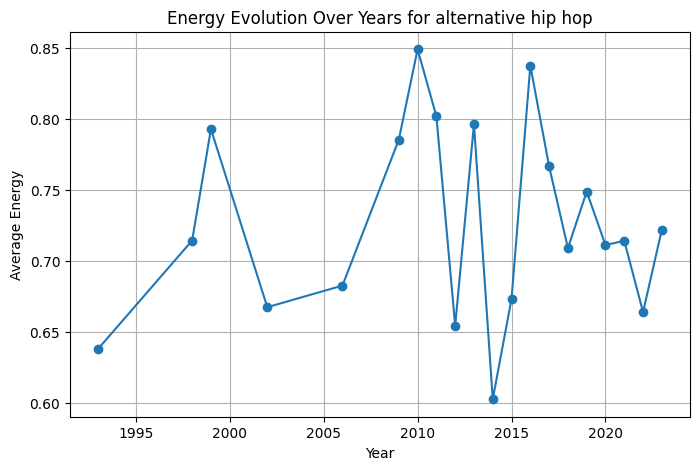

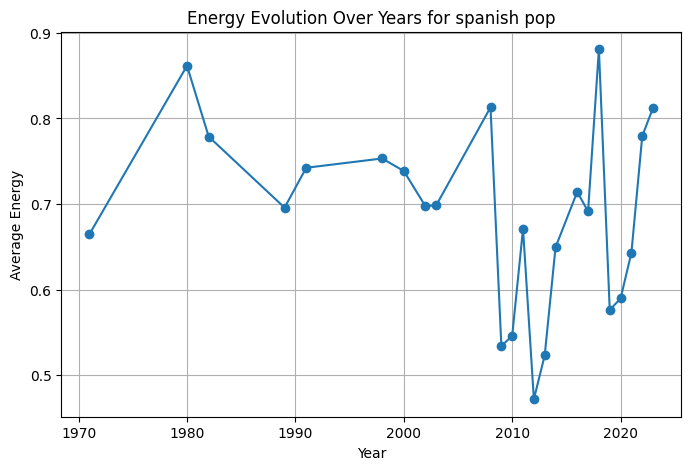

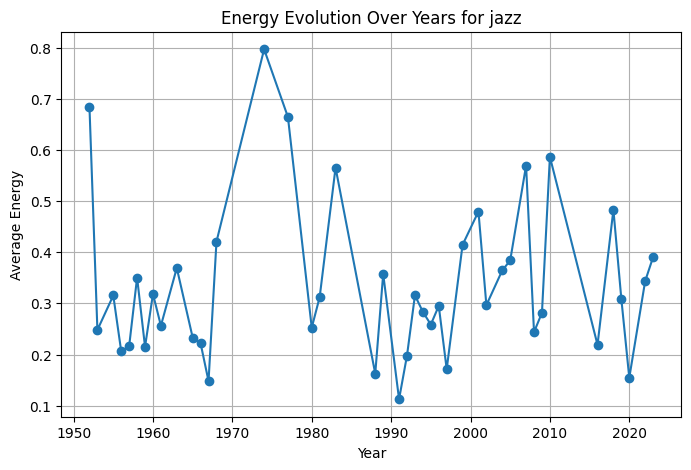

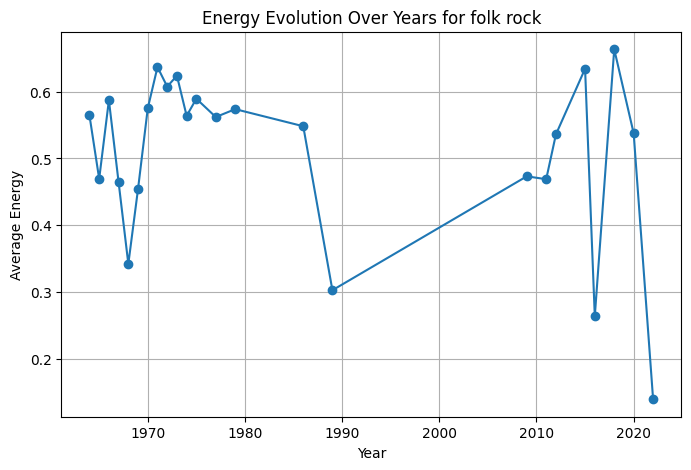

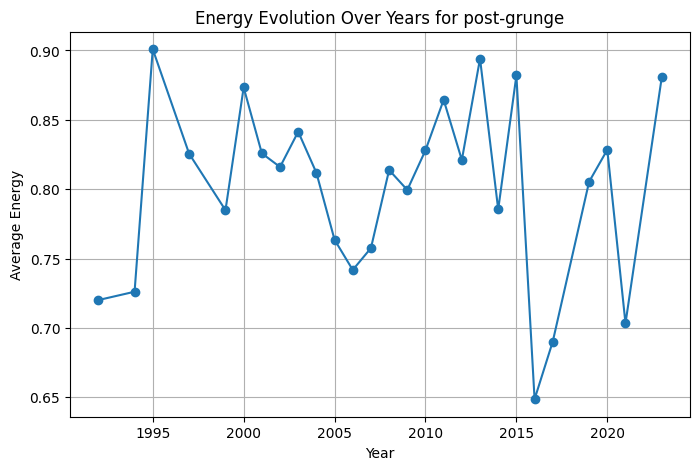

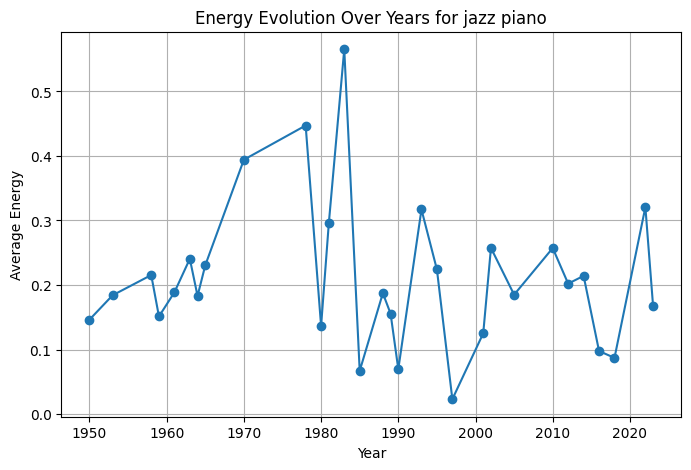

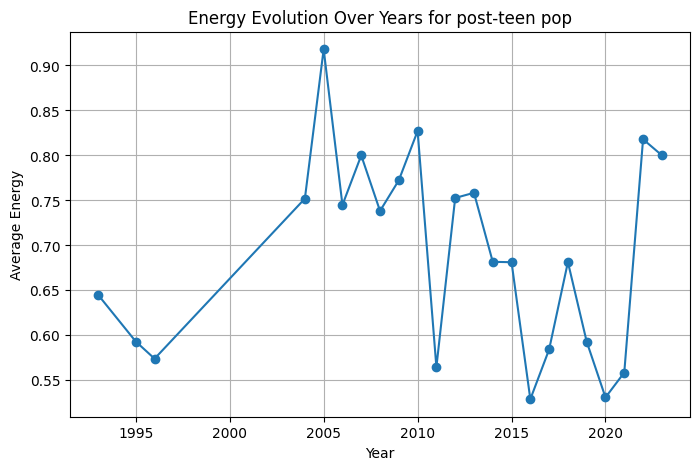

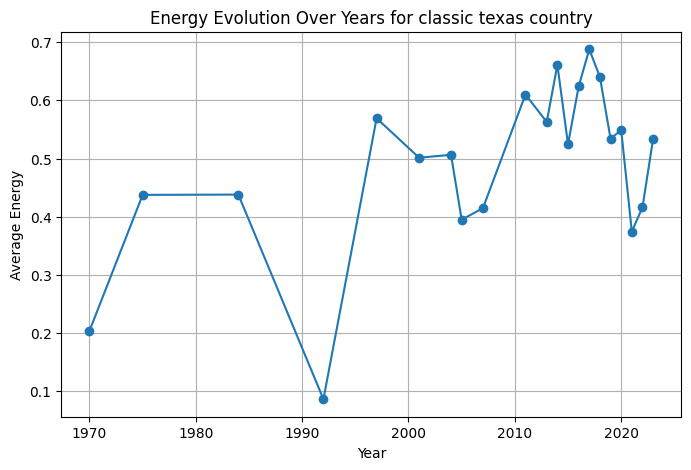

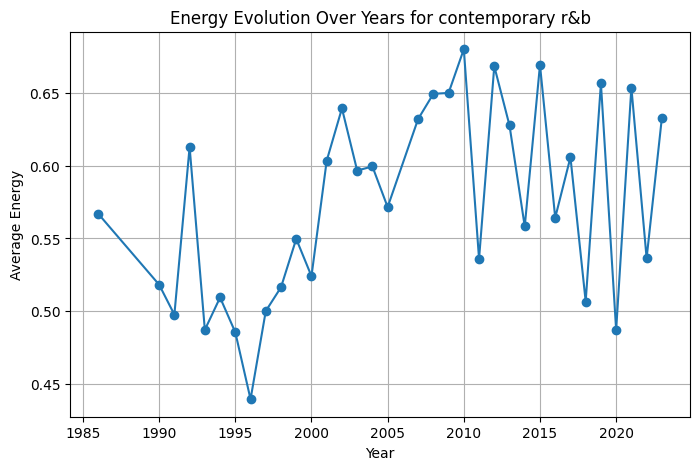

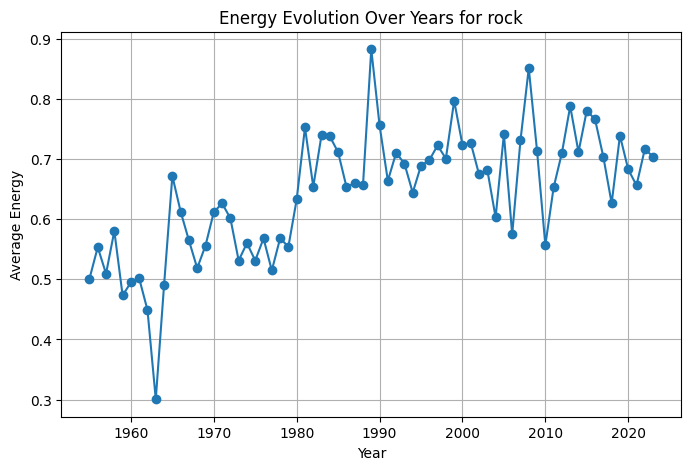

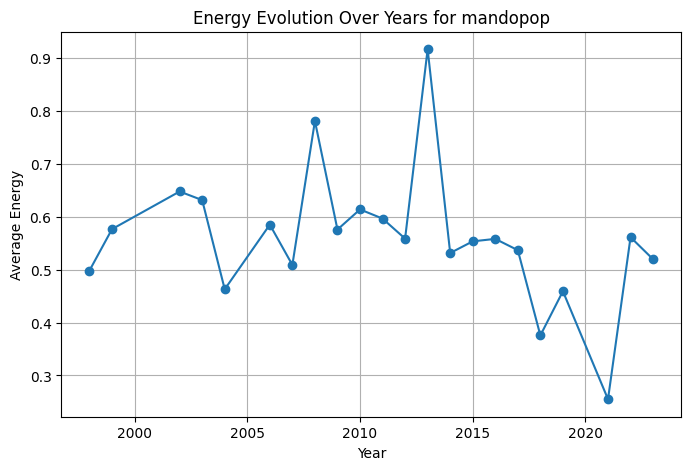

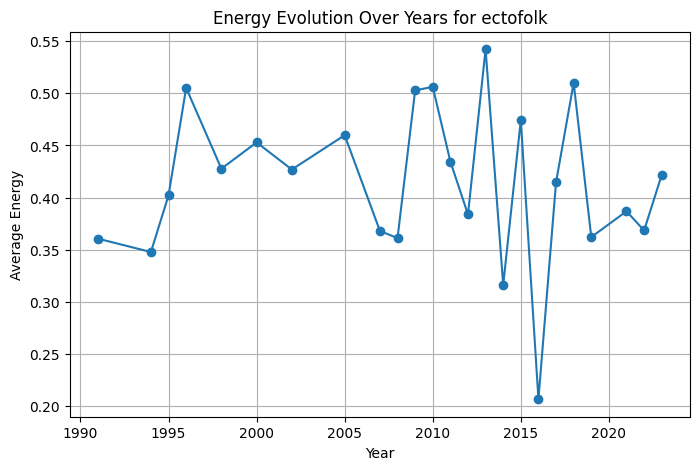

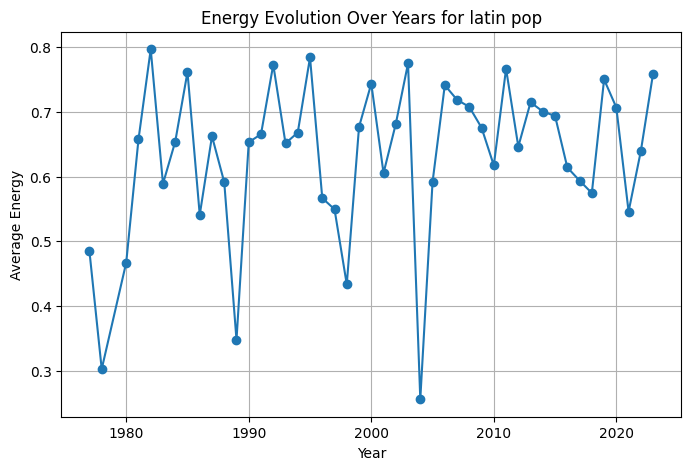

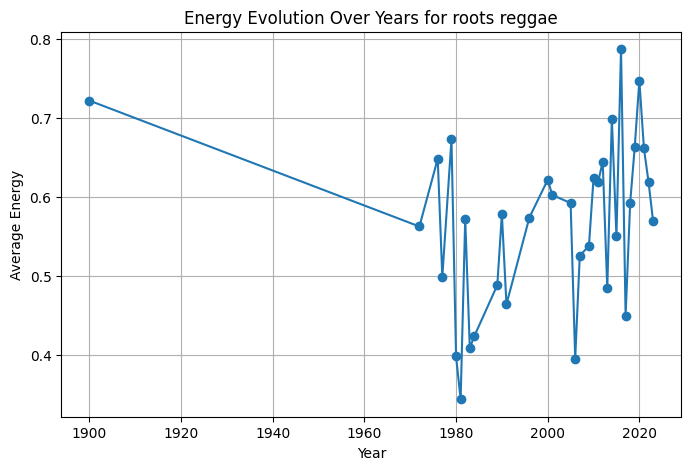

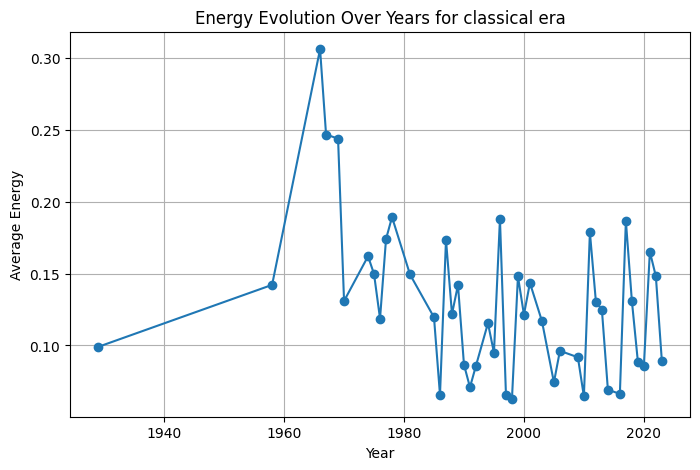

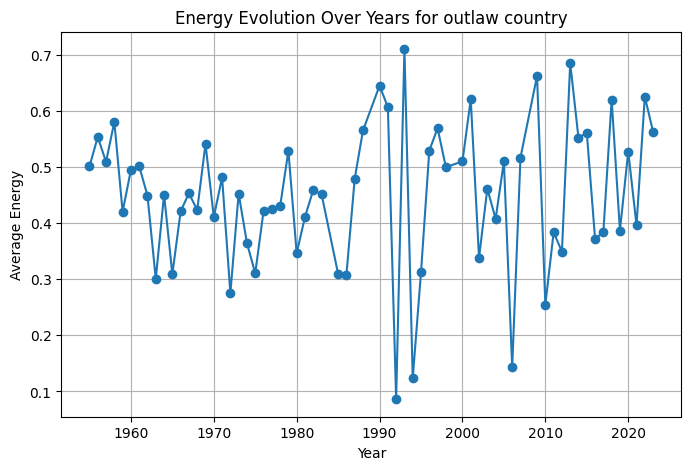

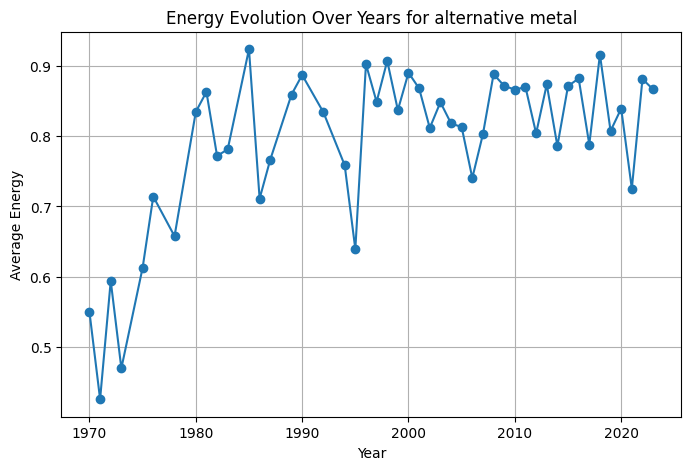

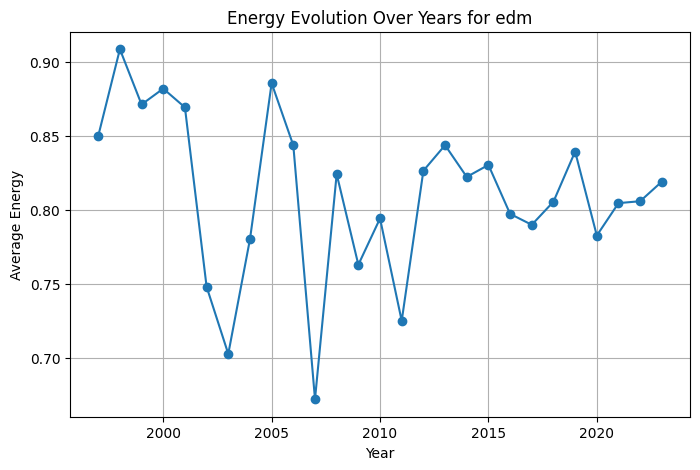

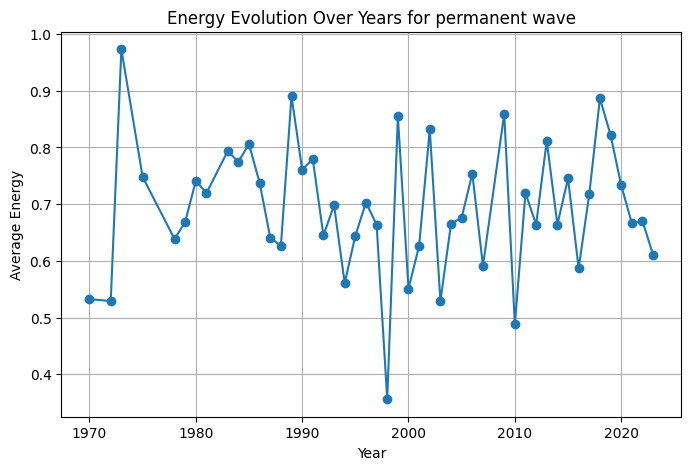

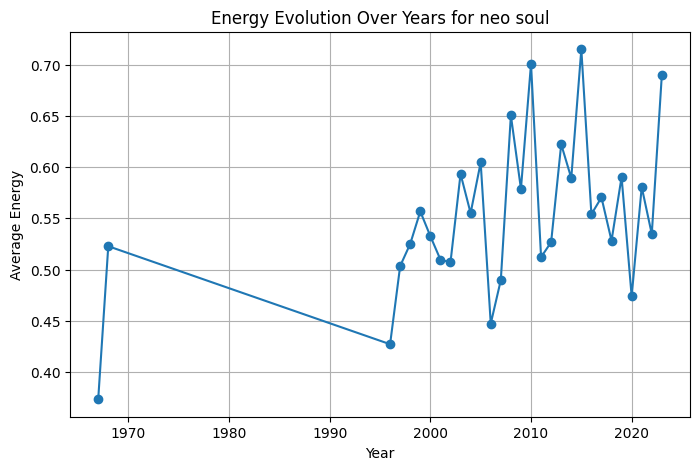

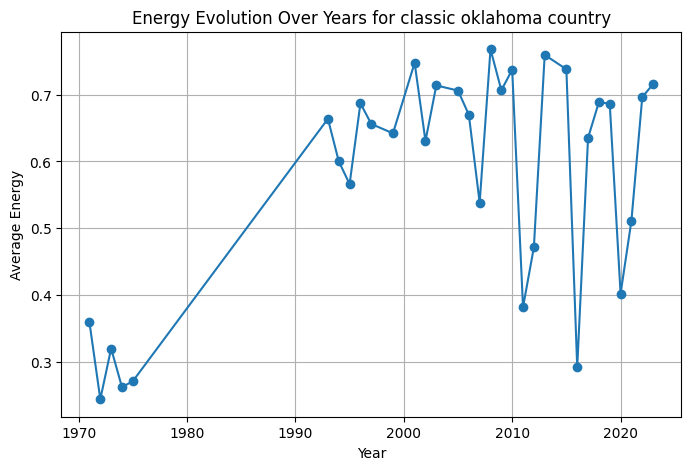

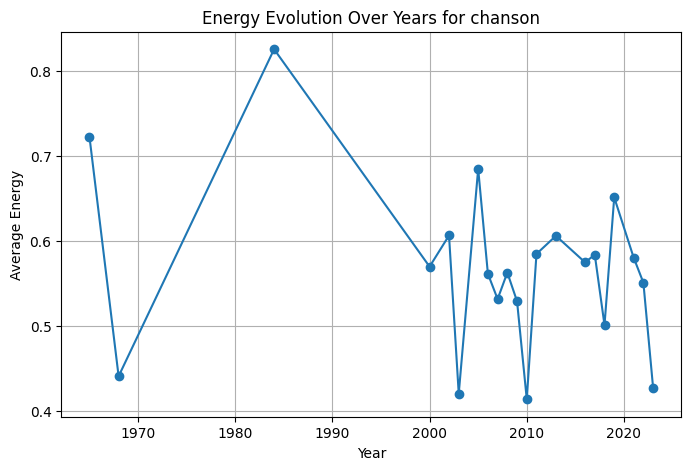

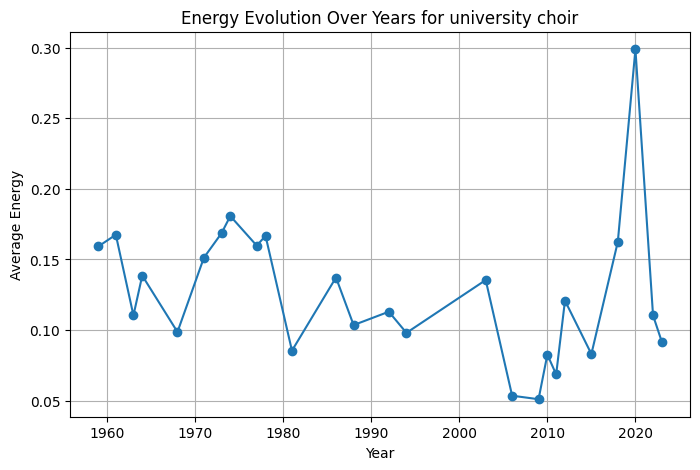

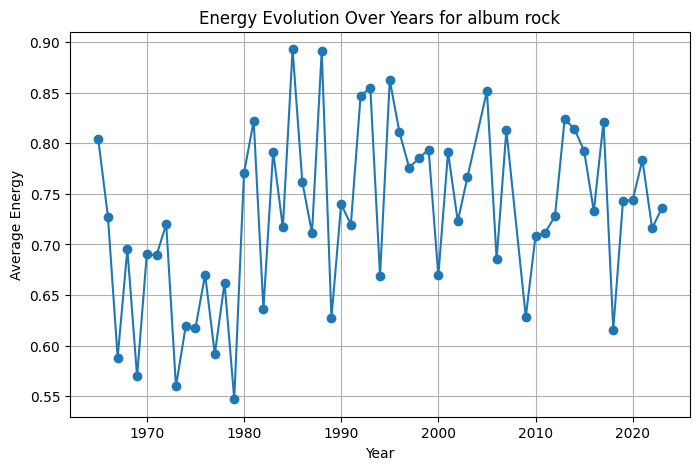

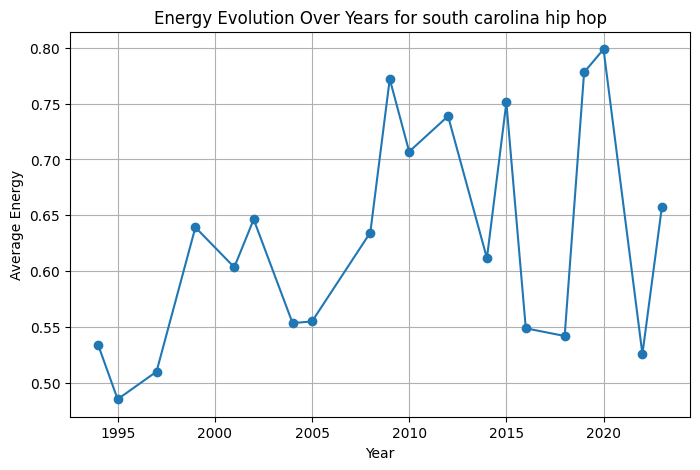

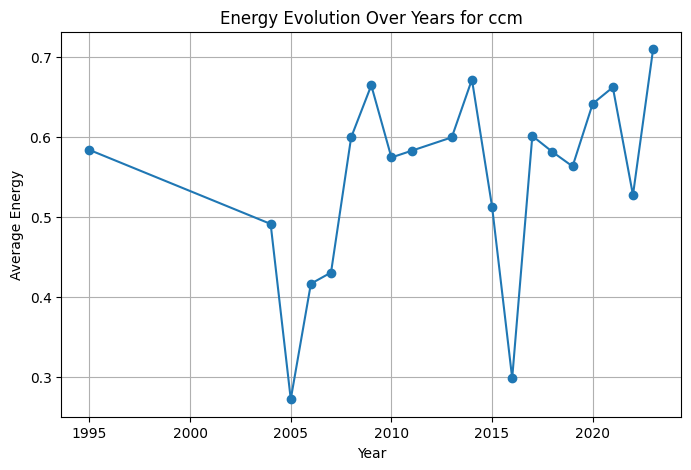

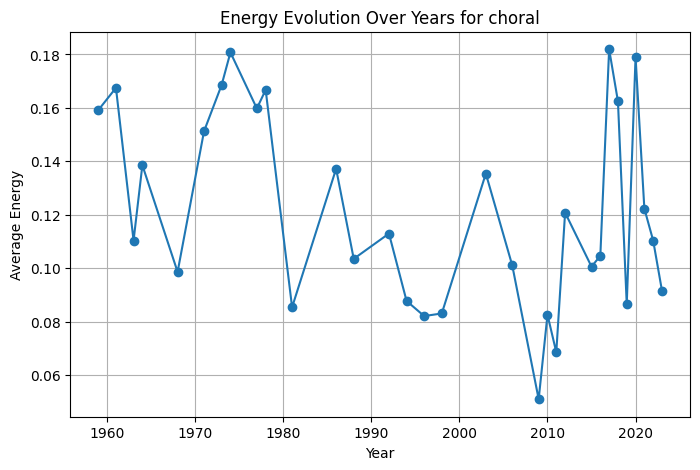

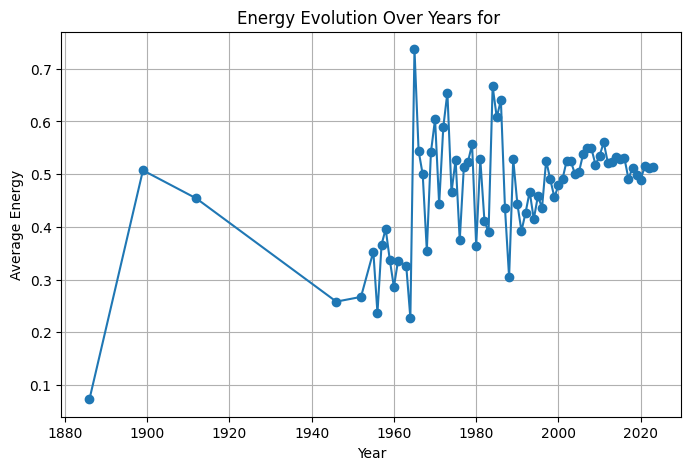

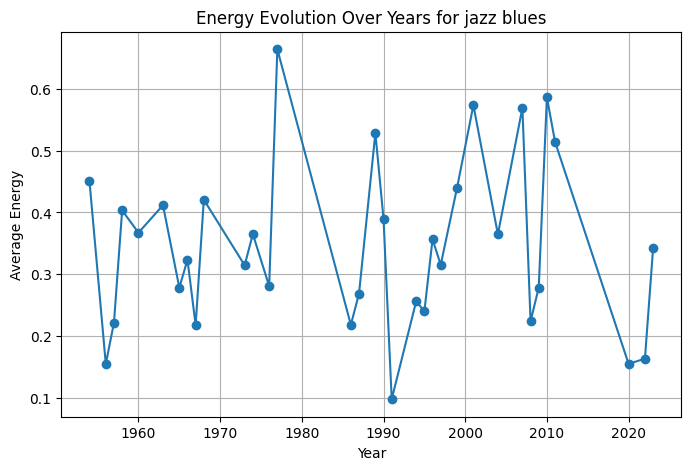

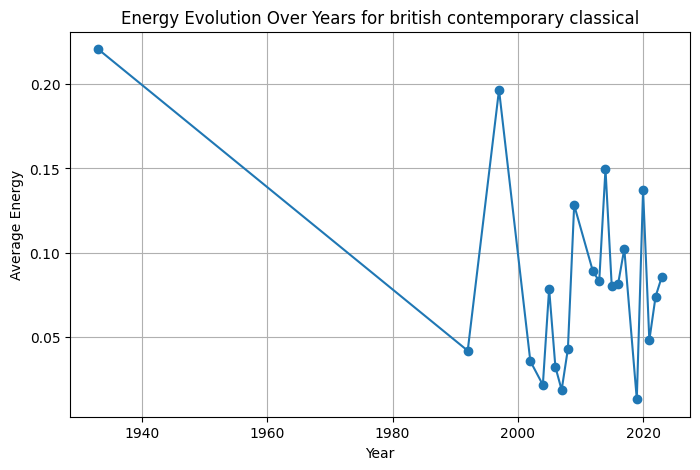

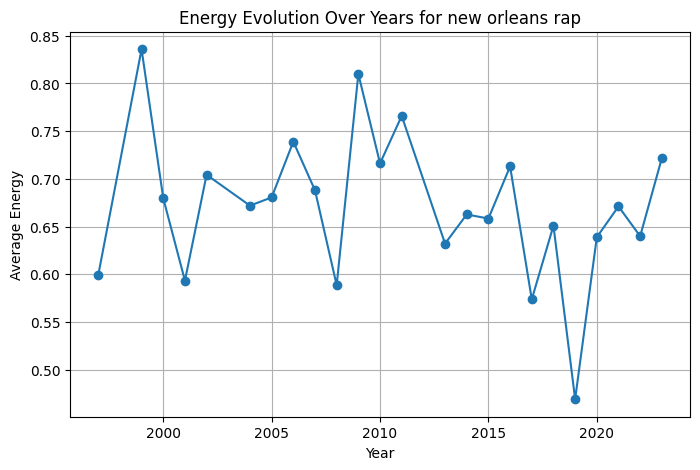

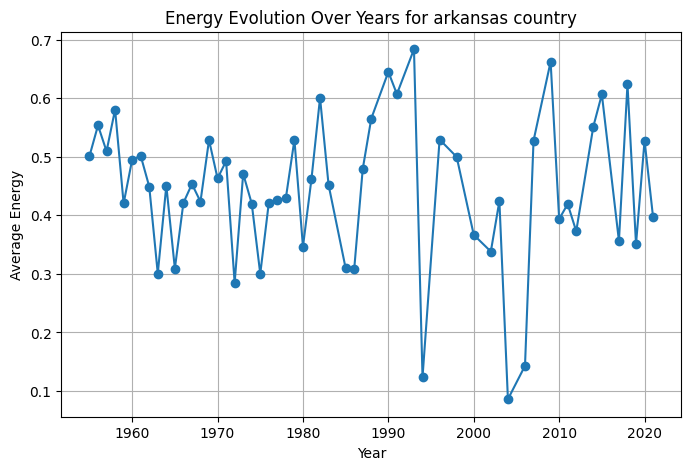

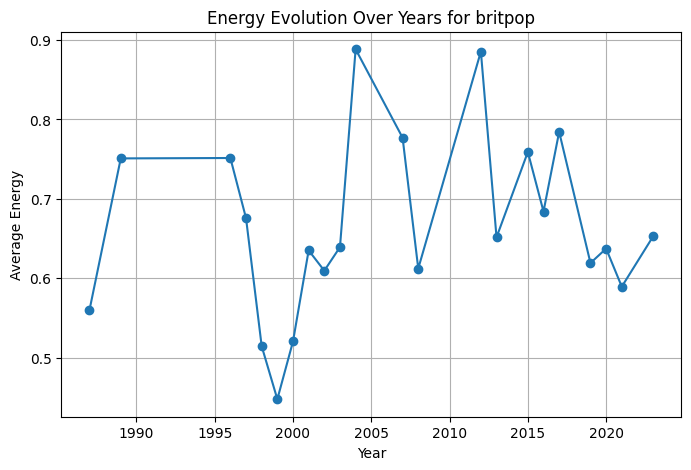

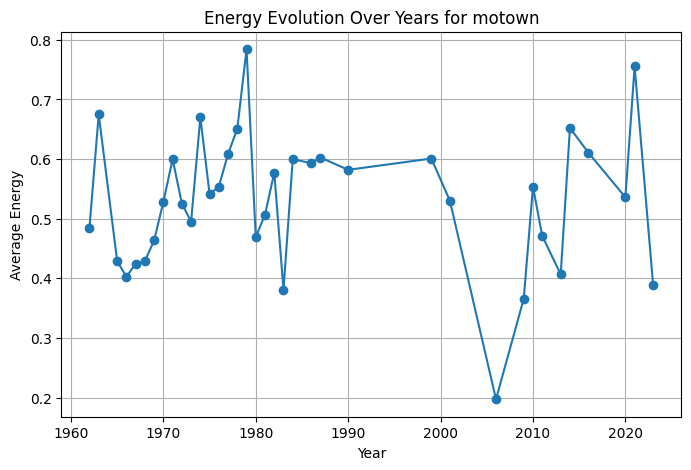

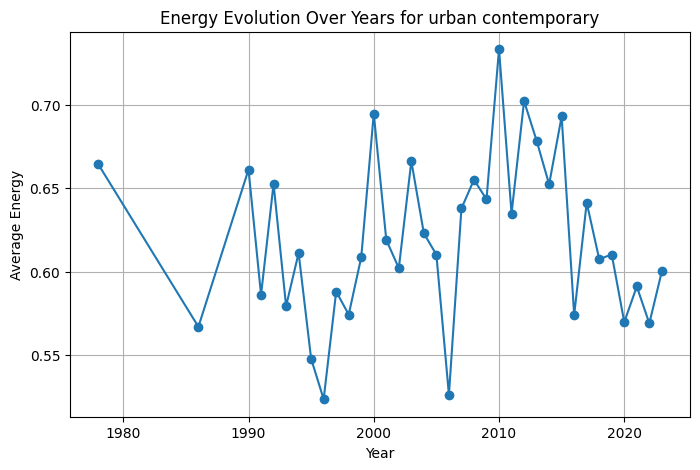

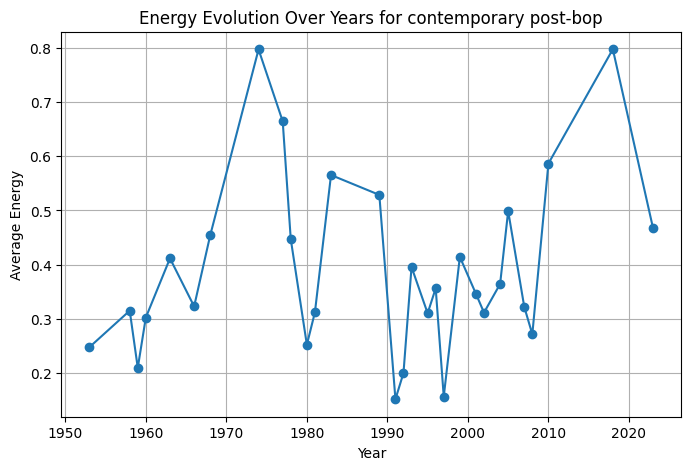

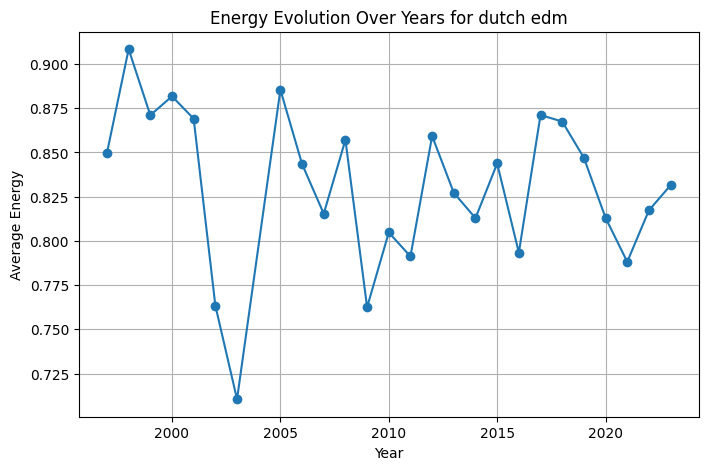

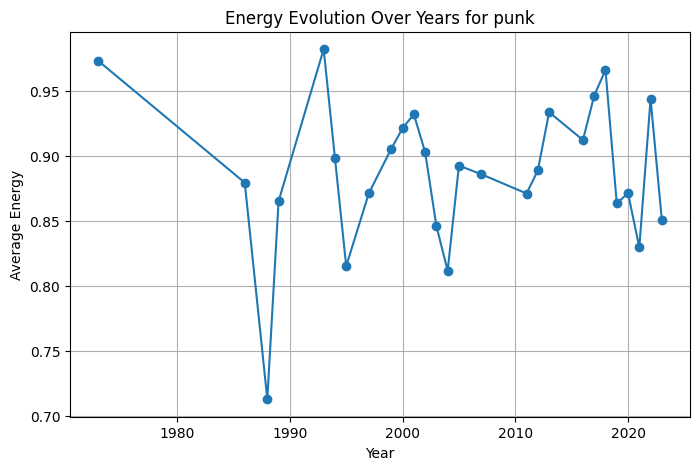

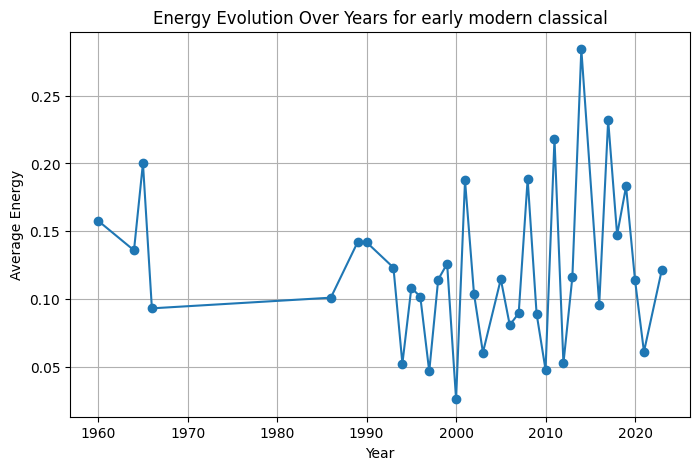

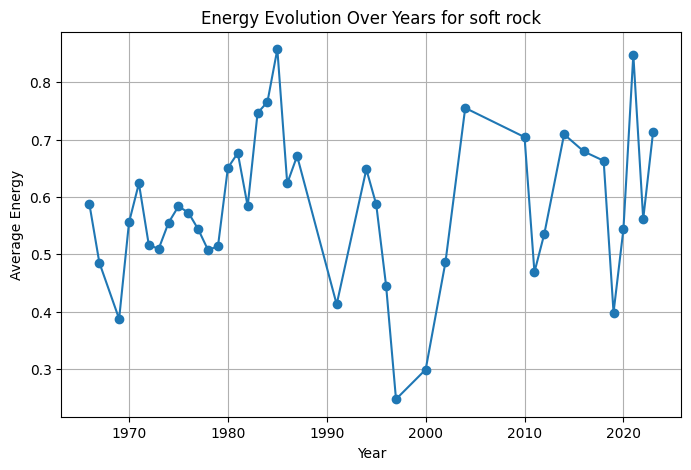

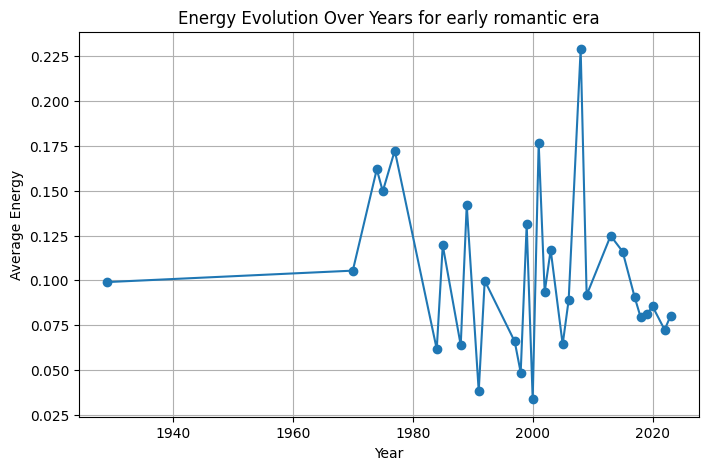

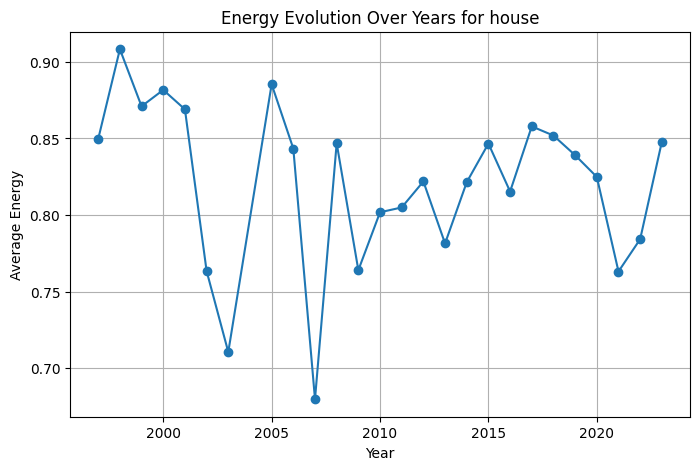

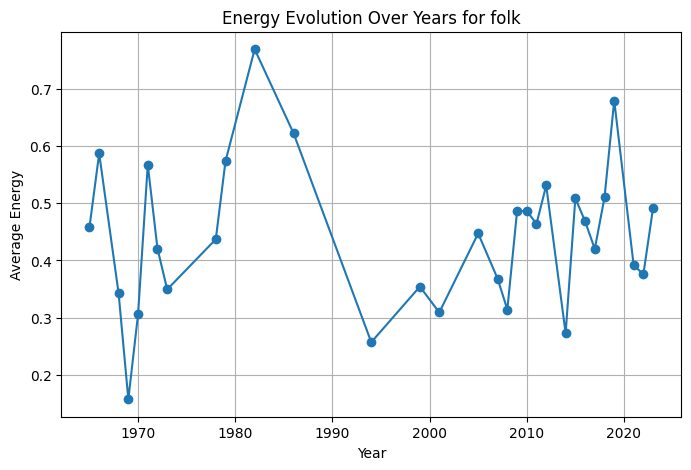

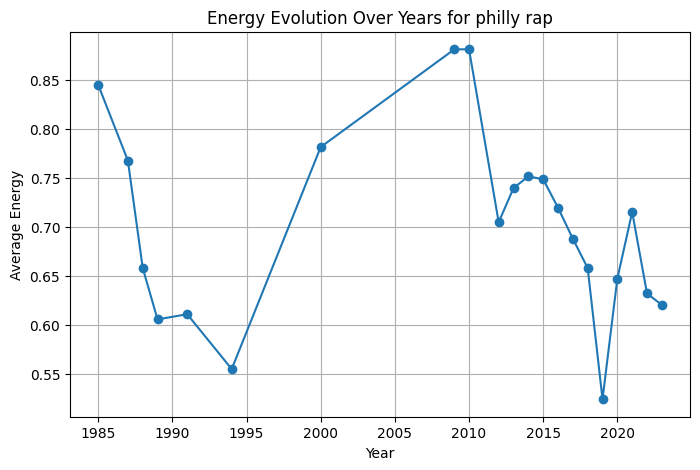

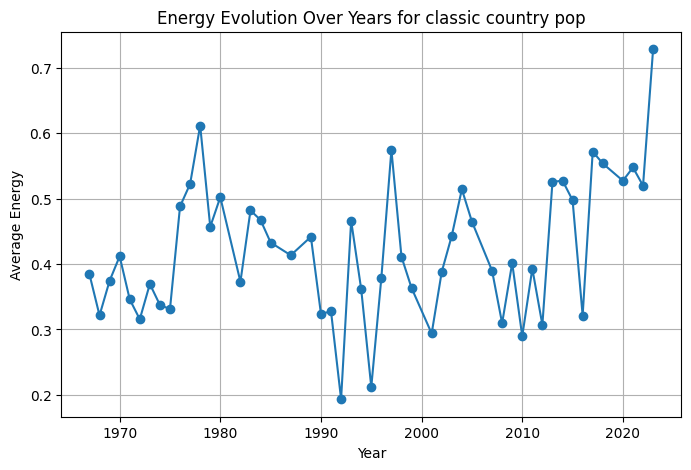

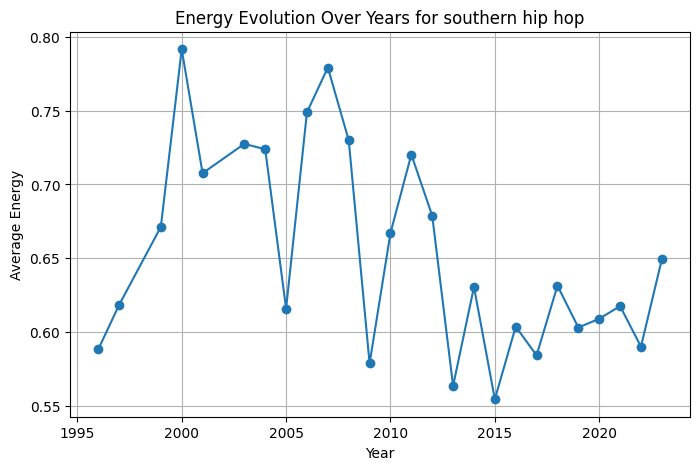

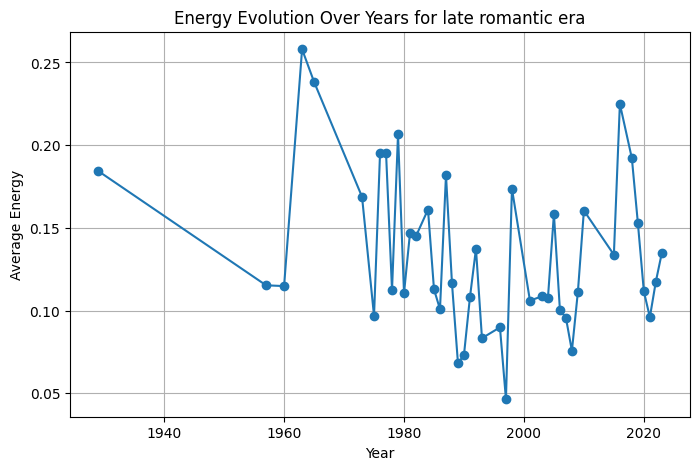

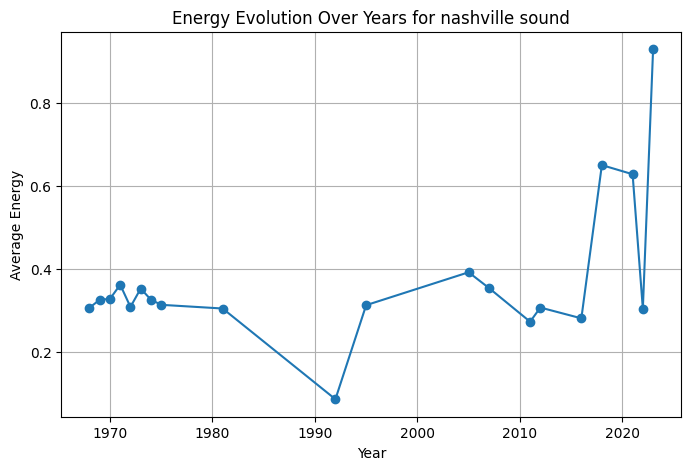

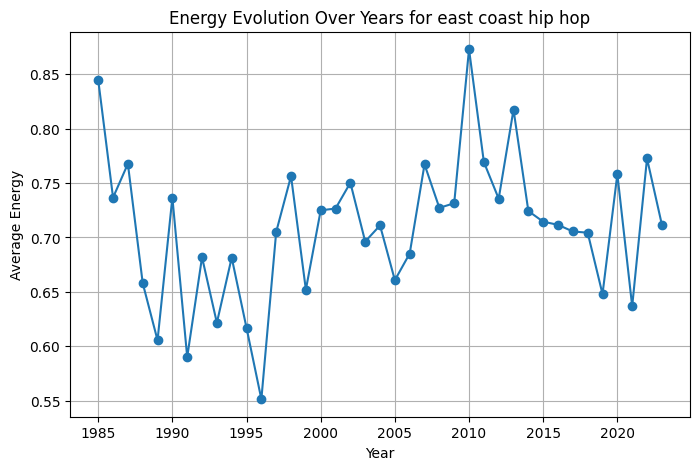

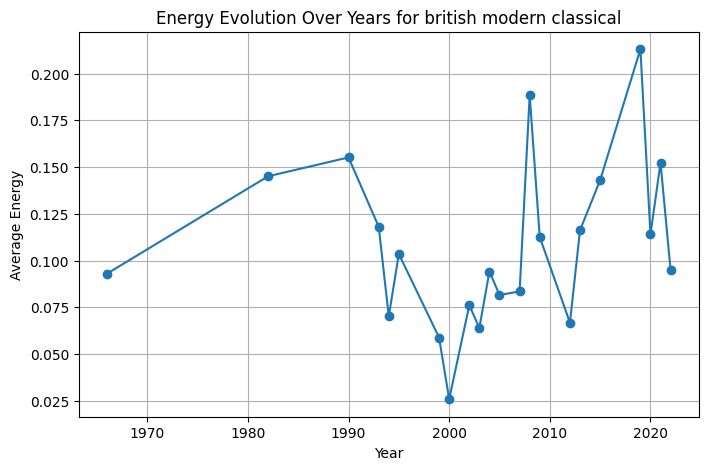

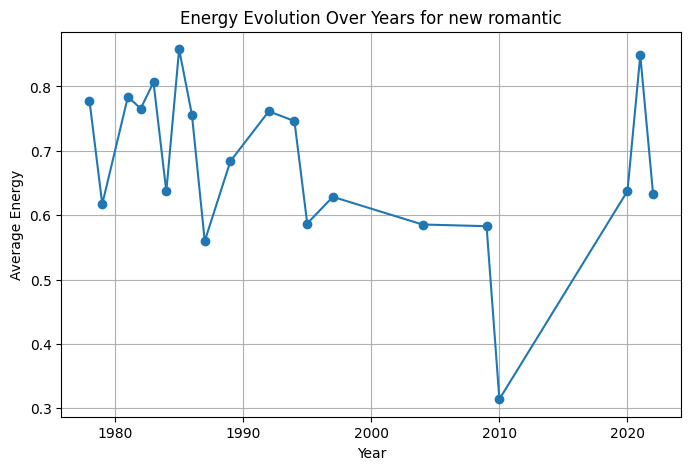

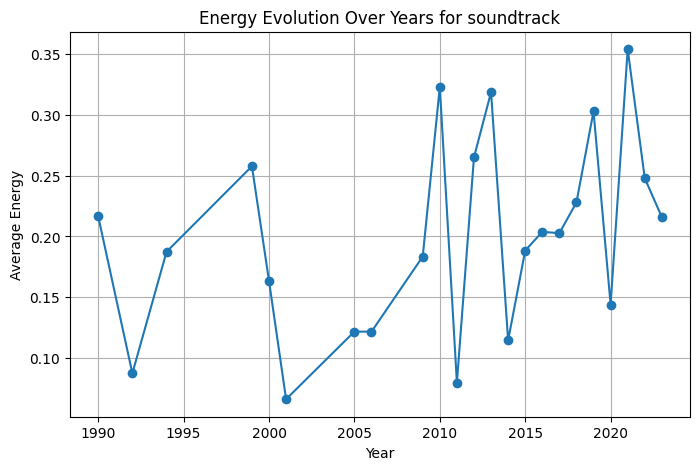

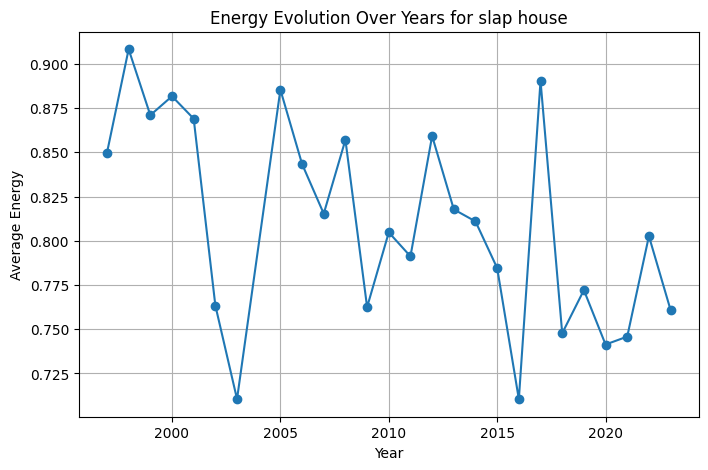

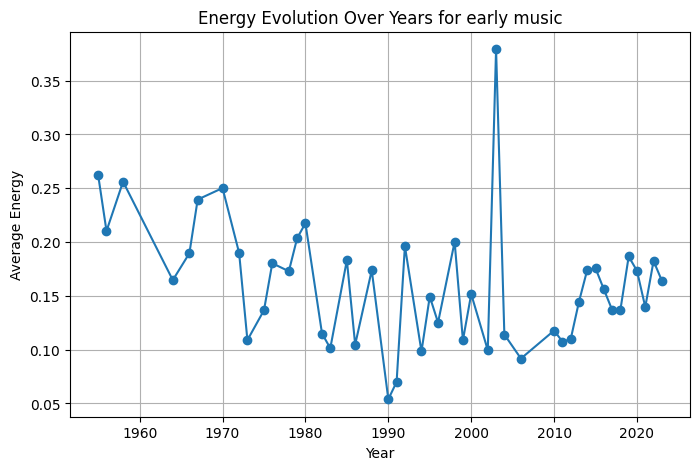

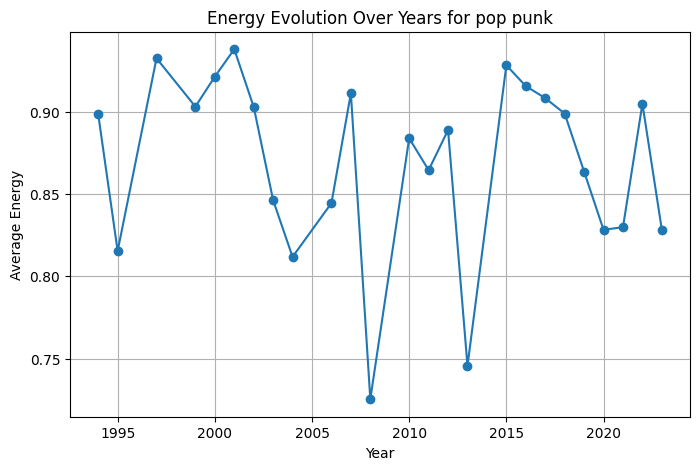

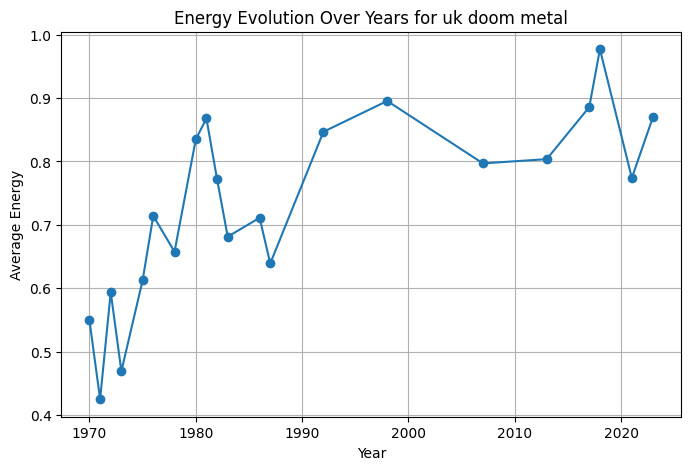

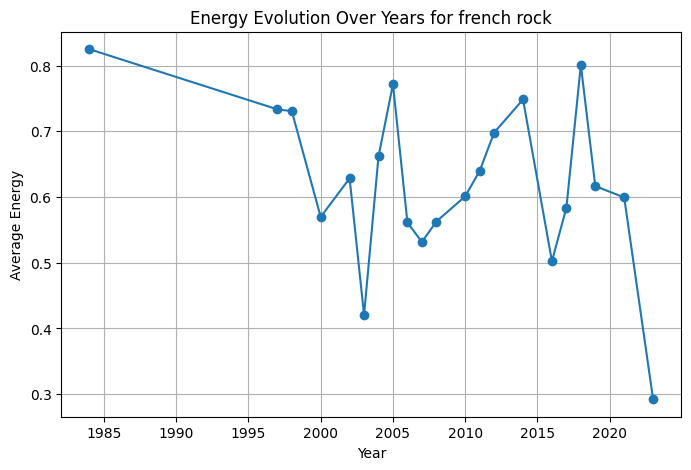

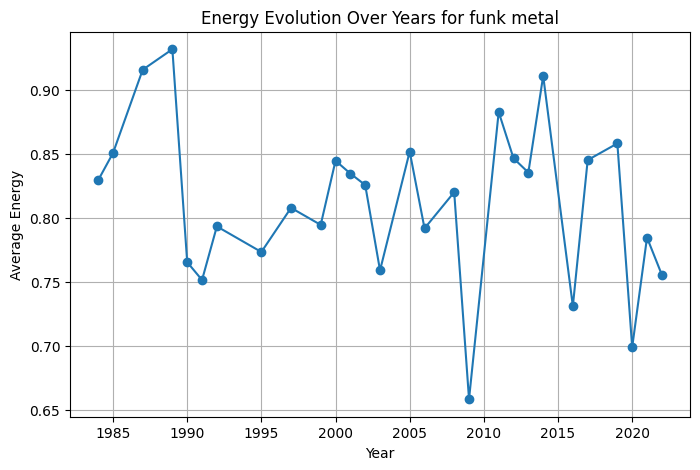

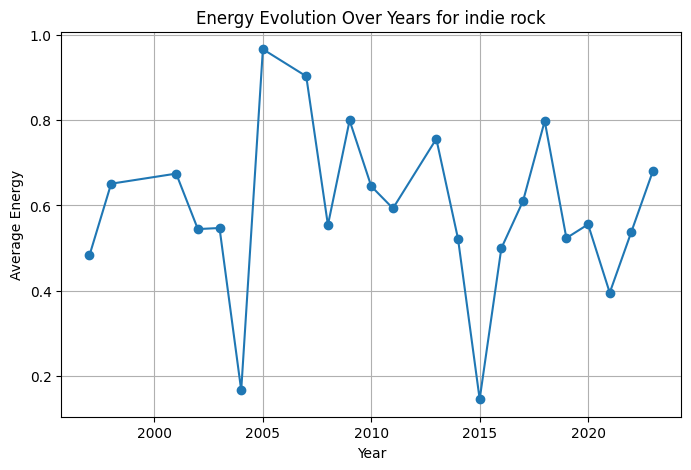

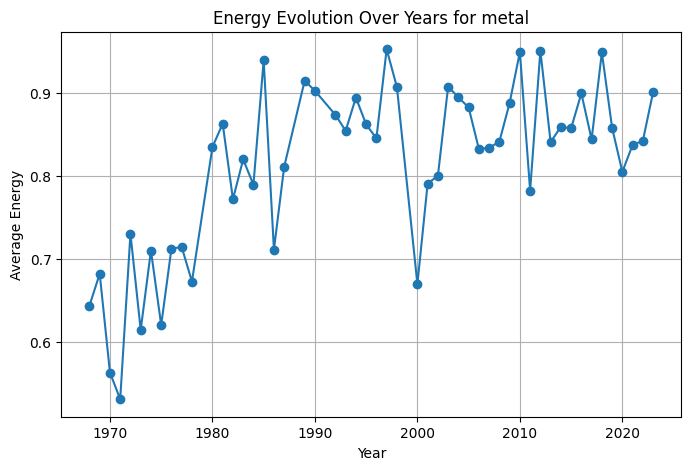

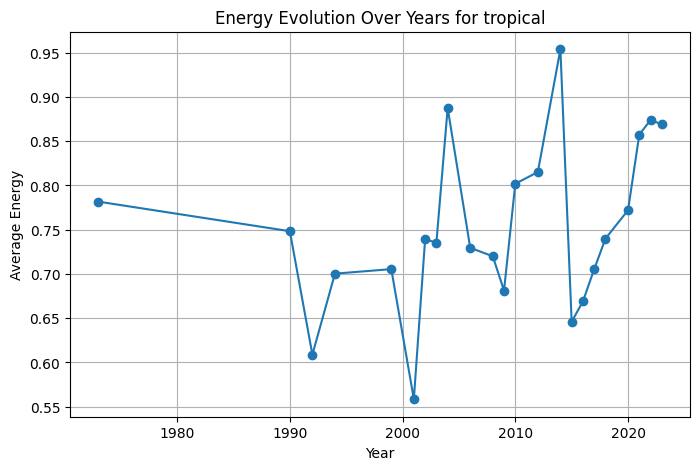

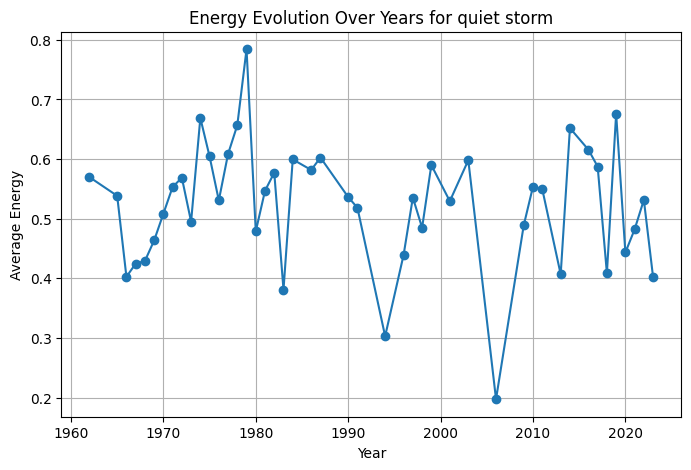

In [ ]:
import pandas as pd

# Filter genres with more than 20 years recorded
filtered_result = [item for item in result_query10 if len(item['evolution']) >= 20]

# Iterate over each genre and create a separate plot
for genre_data in filtered_result:
    genre = genre_data['_id']
    evolution = genre_data['evolution']

    # Create a DataFrame for the current genre
    df_genre = pd.DataFrame(evolution)

    # Plot the data
    plt.figure(figsize=(8, 5))
    plt.plot(df_genre['year'], df_genre['average_energy'], marker='o')
    plt.title(f'Energy Evolution Over Years for {genre}')
    plt.xlabel('Year')
    plt.ylabel('Average Energy')
    plt.grid(True)
    plt.show()